In [58]:
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, sqrt
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [35]:
# Read the data
x_train = pd.read_csv('train.csv', index_col='Id')
x_test = pd.read_csv('test.csv', index_col='Id')

print("Full train dataset shape is {}".format(x_train.shape))
print("Full train dataset shape is {}".format(x_test.shape))

Full train dataset shape is (1460, 80)
Full train dataset shape is (1459, 79)


In [36]:
x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

Based on the output of x_train.info(), I observe that there are several columns with missing values. Some notable ones with a significant number of missing entries include LotFrontage, Alley, MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Electrical, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, and MiscFeature. These missing values will need to be handled before building a machine learning mode

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


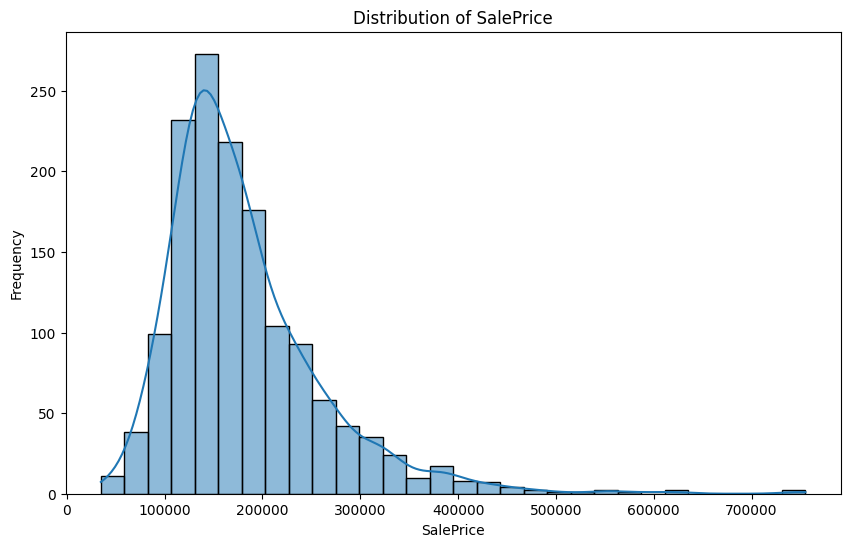

In [38]:
print(x_train['SalePrice'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(x_train['SalePrice'], bins=30, kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

**distribution of SalePrice**

The distribution of SalePrice appears to be right-skewed, meaning there are a few houses with significantly higher sale prices than the majority. The average sale price is around $180,921, with a standard deviation of about $$180,921, with a standard deviation of about $79,442. The prices range from $34,900 to $755,00

In [60]:
#skewness and kurtosis
print("Skewness: %f" % x_train['SalePrice'].skew())
print("Kurtosis: %f" % x_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


The skewness value of 1.882876 confirms that the SalePrice distribution is positively skewed (right-skewed), as we observed from the histogram. This means there's a longer tail on the right side of the distribution due to a few high sale prices. The kurtosis value of 6.536282 indicates that the distribution has heavier tails and a sharper peak compared to a normal distribution. This suggests the presence of outliers or extreme values in the SalePrice data.

In [39]:
def get_numeric_columns(df):
    """
    Extract numeric columns from a DataFrame.

    Parameters:
    df (pd.DataFrame): Input dataframe

    Returns:
    list: List of numeric column names
    pd.DataFrame: DataFrame with only numeric columns
    """
    # Get columns with numeric data types
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_df = df[numeric_columns]

    return numeric_columns, numeric_df

In [40]:
def get_categorical_columns(df):
    """
    Extract categorical columns from a DataFrame.

    Parameters:
    df (pd.DataFrame): Input dataframe

    Returns:
    list: List of categorical column names
    pd.DataFrame: DataFrame with only categorical columns
    """
    # Get columns with object/categorical data types
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_df = df[categorical_columns]

    return categorical_columns, categorical_df

In [41]:
def get_all_feature_types(df):
    """
    Get both numeric and categorical columns from a DataFrame.

    Parameters:
    df (pd.DataFrame): Input dataframe

    Returns:
    dict: Dictionary containing numeric and categorical column info
    """
    numeric_cols, numeric_df = get_numeric_columns(df)
    categorical_cols, categorical_df = get_categorical_columns(df)

    feature_info = {
        'numeric_columns': numeric_cols,
        'categorical_columns': categorical_cols,
        'numeric_data': numeric_df,
        'categorical_data': categorical_df,
        'total_numeric': len(numeric_cols),
        'total_categorical': len(categorical_cols)
    }

    return feature_info

In [42]:
def display_column_info(df):
    """
    Display detailed information about numeric and categorical columns.

    Parameters:
    df (pd.DataFrame): Input dataframe
    """
    feature_info = get_all_feature_types(df)

    print("Dataset Overview:")
    print(f"Total columns: {len(df.columns)}")
    print(f"Numeric columns: {feature_info['total_numeric']}")
    print(f"Categorical columns: {feature_info['total_categorical']}")
    print("\n" + "="*50)

    print("\nNumeric Columns:")
    for col in feature_info['numeric_columns']:
        print(f"  - {col} ({df[col].dtype})")

    print("\nCategorical Columns:")
    for col in feature_info['categorical_columns']:
        print(f"  - {col} ({df[col].dtype})")

In [55]:
print("Original DataFrame:")
print(x_train.head())
print("\n" + "="*60 + "\n")
print(f"\nData types:\n{x_train.dtypes}")
print("\n" + "="*60 + "\n")

Original DataFrame:
    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    Al

In [54]:
# Method 1: Get numeric columns only
numeric_cols, numeric_df = get_numeric_columns(x_train)
print("Numeric columns:", numeric_cols) ## ccolumns names
print("\nNumeric data:")
print(numeric_df.head()) ### numaric dataset
print("\n" + "="*60 + "\n")

Numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

Numeric data:
    MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                          
1           60         65.0     8450            7            5       2003   
2           20         80.0     9600            6            8       1976   
3           60         68.0    11250            7            5       2001   
4           70         60.0     9550            7            5       

In [52]:
# Method 2: Get categorical columns only
categorical_cols, categorical_df = get_categorical_columns(x_train)
print("Categorical columns:", categorical_cols)
print("\nCategorical data:")
print(categorical_df.head())
print("\n" + "="*60 + "\n")

Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Categorical data:
   MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
Id                                                                            
1        RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
2        RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
3        RL   Pave   NaN      IR1         Lvl    AllPub    Insid

In [46]:
# Method 3: Get all feature information
feature_info = get_all_feature_types(x_train)
print("Complete feature information:")
print(f"Numeric columns ({len(feature_info['numeric_columns'])}): {feature_info['numeric_columns']}")
print(f"Categorical columns ({len(feature_info['categorical_columns'])}): {feature_info['categorical_columns']}")
print("\n" + "="*60 + "\n")

Complete feature information:
Numeric columns (37): ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
Categorical columns (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Kitche

In [47]:
# Method 4: Display detailed column info
display_column_info(x_train)

Dataset Overview:
Total columns: 80
Numeric columns: 37
Categorical columns: 43


Numeric Columns:
  - MSSubClass (int64)
  - LotFrontage (float64)
  - LotArea (int64)
  - OverallQual (int64)
  - OverallCond (int64)
  - YearBuilt (int64)
  - YearRemodAdd (int64)
  - MasVnrArea (float64)
  - BsmtFinSF1 (int64)
  - BsmtFinSF2 (int64)
  - BsmtUnfSF (int64)
  - TotalBsmtSF (int64)
  - 1stFlrSF (int64)
  - 2ndFlrSF (int64)
  - LowQualFinSF (int64)
  - GrLivArea (int64)
  - BsmtFullBath (int64)
  - BsmtHalfBath (int64)
  - FullBath (int64)
  - HalfBath (int64)
  - BedroomAbvGr (int64)
  - KitchenAbvGr (int64)
  - TotRmsAbvGrd (int64)
  - Fireplaces (int64)
  - GarageYrBlt (float64)
  - GarageCars (int64)
  - GarageArea (int64)
  - WoodDeckSF (int64)
  - OpenPorchSF (int64)
  - EnclosedPorch (int64)
  - 3SsnPorch (int64)
  - ScreenPorch (int64)
  - PoolArea (int64)
  - MiscVal (int64)
  - MoSold (int64)
  - YrSold (int64)
  - SalePrice (int64)

Categorical Columns:
  - MSZoning (object)
  - S

In [56]:
def plot_histograms(df, figsize=None, bins='auto', kde=True, title_prefix="Distribution of"):
    """
    Plot histograms for all numeric columns in a dataset.

    Parameters:
    df (pd.DataFrame): Input dataframe
    figsize (tuple): Figure size (width, height). If None, auto-calculated
    bins (int or str): Number of bins or method ('auto', 'sturges', 'fd', 'scott', 'stone', 'rice', 'sqrt')
    kde (bool): Whether to overlay KDE curve
    title_prefix (str): Prefix for plot titles
    """
    # Get only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    if not numeric_columns:
        print("No numeric columns found in the dataset!")
        return

    n_cols = len(numeric_columns)

    # Calculate grid dimensions
    if n_cols == 1:
        n_rows, n_columns = 1, 1
    elif n_cols == 2:
        n_rows, n_columns = 1, 2
    else:
        n_columns = 3
        n_rows = ceil(n_cols / n_columns)

    # Auto-calculate figure size if not provided
    if figsize is None:
        width = n_columns * 5
        height = n_rows * 4
        figsize = (width, height)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_columns, figsize=figsize)
    fig.suptitle(f'Histogram Analysis - {len(numeric_columns)} Numeric Features', fontsize=16, y=1.02)

    # Handle single subplot case
    if n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_cols > 1 else [axes]
    else:
        axes = axes.flatten()

    # Plot histograms
    for i, col in enumerate(numeric_columns):
        ax = axes[i]

        # Remove missing values for plotting
        data = df[col].dropna()

        if len(data) == 0:
            ax.text(0.5, 0.5, f'No data\navailable for\n{col}',
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{title_prefix} {col}')
            continue

        # Plot histogram
        if kde and len(data) > 1:
            sns.histplot(data=data, bins=bins, kde=True, ax=ax, alpha=0.7)
        else:
            ax.hist(data, bins=bins, alpha=0.7, edgecolor='black', linewidth=0.5)

        # Customize plot
        ax.set_title(f'{title_prefix} {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)

        # Add statistics text
        mean_val = data.mean()
        std_val = data.std()
        median_val = data.median()

        stats_text = f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}\nMedian: {median_val:.2f}\nCount: {len(data)}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
               fontsize=9)

    # Hide empty subplots
    for i in range(n_cols, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()


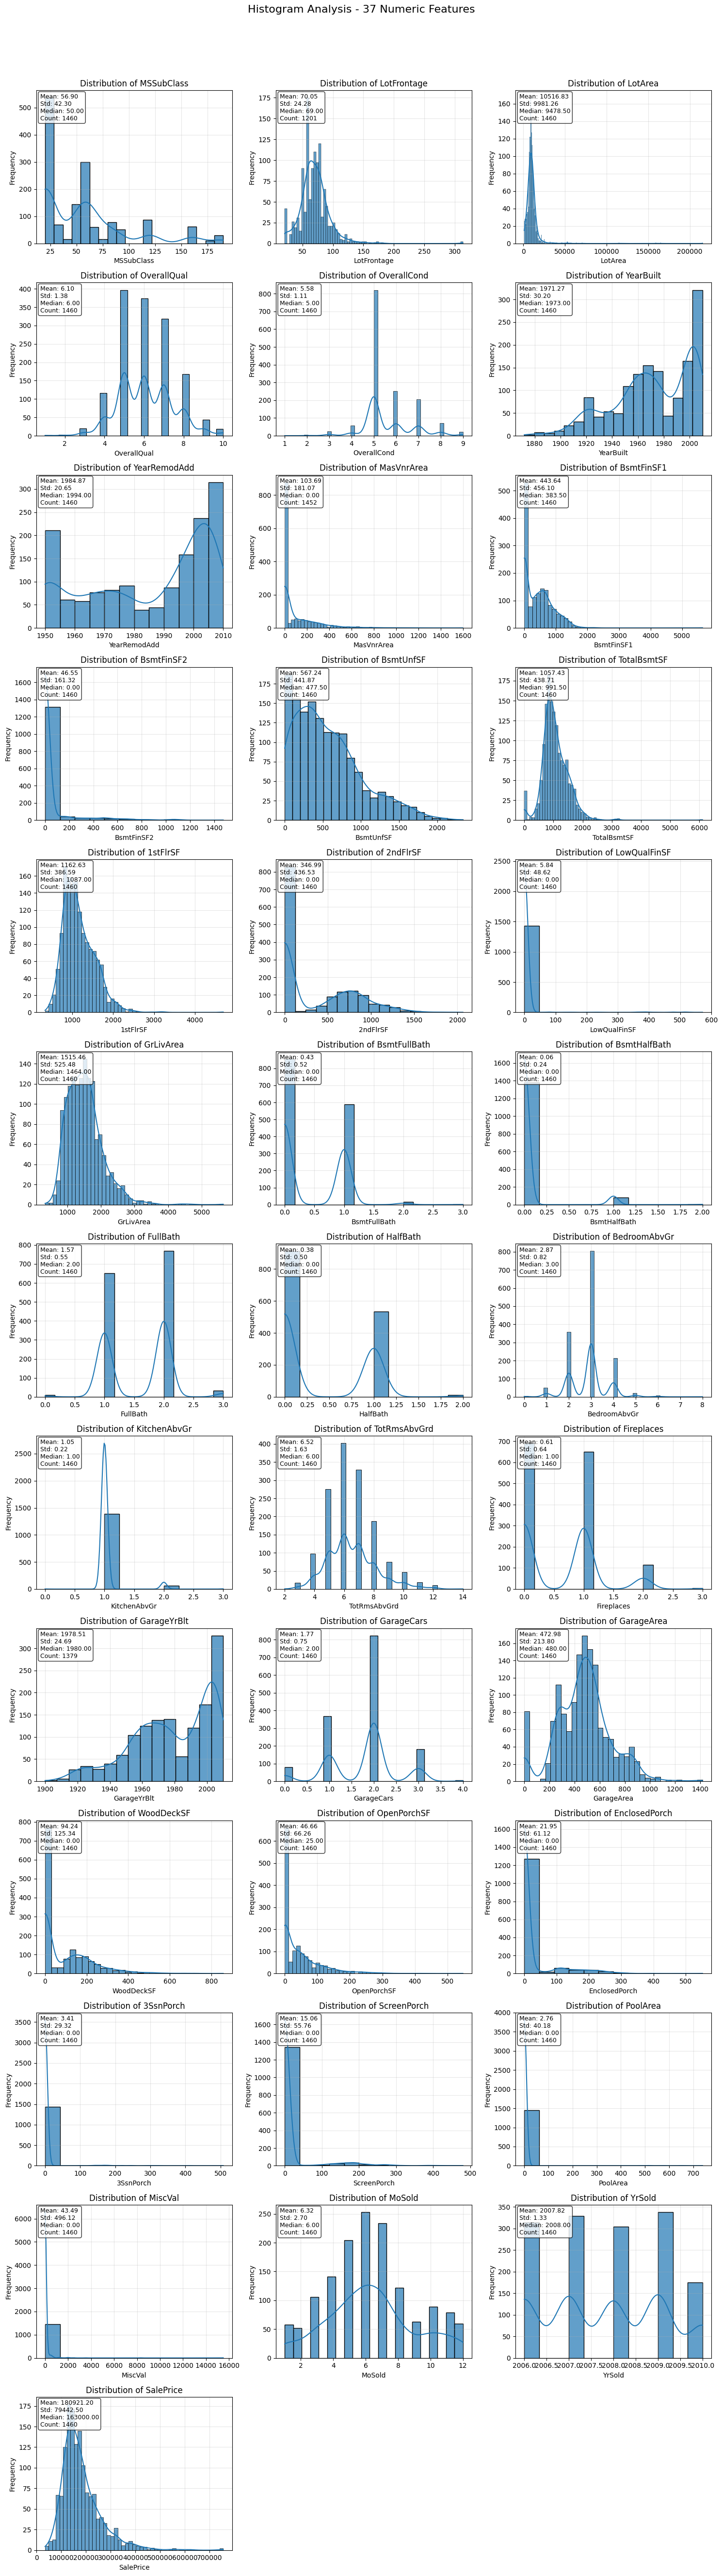

In [59]:
plot_histograms(x_train)